https://wikidocs.net/24586
https://wikidocs.net/44249

코랩으로 보시는 게 편할 것 같아요!  
https://colab.research.google.com/drive/1Ws94iXUUErxEgQg21M-04R8BIyBUlNgh?authuser=1#scrollTo=X4kZt-XOhfSn

In [1]:
import pandas as pd 
import numpy as np 
from google.colab import drive
drive.mount('/content/drive', force_remount=True) 
import tensorflow as tf
import os
import matplotlib.pyplot as plt

os.chdir('/content/drive/MyDrive/nlp_toxic') 
os.listdir()

Mounted at /content/drive


['glove.6B.100d.txt',
 'glove.6B.200d.txt',
 'glove.6B.50d.txt',
 'glove.6B.300d.txt',
 'GoogleNews-vectors-negative300.bin.gz',
 'glove.6B.zip',
 'train.csv',
 'test.csv',
 'sample_submission.csv',
 'test_labels.csv',
 'toxic_0324.ipynb',
 'toxic_0331.ipynb',
 'w2v_cbow',
 'w2v_sgns',
 'w2v_sg',
 'toxic_0330.ipynb',
 'train_x.npy',
 'train_y.npy',
 'test_x.npy',
 '0401_w2v_gru.h5',
 'sub_0401_pw2v_gru.csv',
 '0401_pg_gru.h5',
 'sub_0401_pg_gru.csv',
 '0401_w2vc_gru.h5',
 'sub_0401_w2vc_gru.csv',
 '0401_w2vc_gru_2.h5',
 'sub_0401_w2vc_gru_2.csv',
 '0401_ft_gru.h5',
 'sub_0401_ft_gru.csv',
 '0401_g_gru.h5',
 'sub_0401_g_gru.csv',
 'model3.png',
 'vectors.txt',
 'toxic_0401_보영.ipynb']

### 1. load data

In [2]:
train = pd.read_csv("./train.csv")
columns = list(train.columns)
columns = columns[2:]
columns

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [3]:
sample_submission = pd.read_csv("./sample_submission.csv")

In [4]:
test = pd.read_csv("./test.csv")

In [5]:
test_labels = pd.read_csv("./test_labels.csv")

### 2. 데이터 전처리

In [6]:
import re 
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
from nltk.corpus import stopwords  

# 공백 여러개나 줄바꿈 공백 하나로 바꿈
def pre_text(text):
    text = re.sub(r'[^\w\s\'\"]',' ', text) 
    text = re.sub("\s{2,}"," ", text)
    text = re.sub('[0-9]', '', text)
    return text

#불용어
nltk.download('stopwords')
stop_words = stopwords.words('english')
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [8]:
# 토큰화
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# train_text : 토큰화 결과 단어로. 정수 인코딩 전
train_text = []

for x in train['comment_text']:
    x = pre_text(x)
    x = text_to_word_sequence(x)
    tmp = [word for word in x if not word in stop_words] 
    train_text.append(tmp)

train_y = train.iloc[:, 2:8]
train_y = train_y.to_numpy()

In [9]:
# 전처리 후 빈 데이터 제거
empty = []
for i in range(len(train_text)):
    if len(train_text[i]) == 0:
        print(i)
        print(train.iloc[i, :], end='\n\n')
        empty.append(i)

train_text = [i for j, i in enumerate(train_text) if j not in empty]
train_y = [i for j, i in enumerate(train_y) if j not in empty]

2098
id                           05ac7a7a83e4c63a
comment_text     No, it doesn´t.80.228.65.162
toxic                                       0
severe_toxic                                0
obscene                                     0
threat                                      0
insult                                      0
identity_hate                               0
Name: 2098, dtype: object

2407
id                   067638a445ccd93b
comment_text     Here, here and here.
toxic                               0
severe_toxic                        0
obscene                             0
threat                              0
insult                              0
identity_hate                       0
Name: 2407, dtype: object

3990
id                                0aa6f3529219b37e
comment_text     From here\n\nFrom here 160.80.2.8
toxic                                            0
severe_toxic                                     0
obscene                                          0
thre

In [10]:
train_y = pd.DataFrame(train_y)
train_y = train_y.to_numpy()
train_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [11]:
#토큰화
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_text)
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)

# train_x : 정수 인코딩한 것
train_x = tokenizer.texts_to_sequences(train_text)


190060


In [ ]:
# 패딩 전 max_len 결정
print(max(len(l) for l in train_x))

def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

below_threshold_len(200, train_x)
below_threshold_len(150, train_x)
below_threshold_len(100, train_x)

1250
전체 샘플 중 길이가 200 이하인 샘플의 비율: 97.92190369919948
전체 샘플 중 길이가 150 이하인 샘플의 비율: 96.70889726117564
전체 샘플 중 길이가 100 이하인 샘플의 비율: 93.40839137166893


In [12]:
# 패딩 max_len 150으로 결정

max_len = 150
from tensorflow.keras.preprocessing.sequence import pad_sequences

train_x = pad_sequences(train_x, max_len, padding='post')
print(train_y.shape)
print(train_x.shape)

(159521, 6)
(159521, 150)


##### test data 

In [49]:
test_text = []

for x in test['comment_text']:
    x = pre_text(x)
    x = text_to_word_sequence(x)
    tmp = [word for word in x if not word in stop_words] 
    test_text.append(tmp)


In [50]:
test_x = tokenizer.texts_to_sequences(test_text)


In [51]:
test_x = pad_sequences(test_x, max_len, padding='post')

In [52]:
test_y = sample_submission.iloc[:, 1:8]
test_y = test_y.to_numpy()

In [ ]:
print(test_x.shape)
print(test_y.shape)

(153164, 150)
(153164, 6)


In [ ]:
np.save("./train_x.npy", train_x)
np.save("./train_y.npy", train_y)
np.save("./test_x.npy", test_x)


In [ ]:
train_x

array([[  538,    46,    49, ...,     0,     0,     0],
       [90439,  2376,   423, ...,     0,     0,     0],
       [  289,   313,    15, ...,     0,     0,     0],
       ...,
       [32940,  6829,  4767, ...,     0,     0,     0],
       [  439,     8,   111, ...,     0,     0,     0],
       [   53,    11,   145, ...,     0,     0,     0]], dtype=int32)

In [ ]:
test_x = np.load("./test_x.npy")

### 3. Word Embedding

In [13]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.models import FastText
import gensim


##### pretrained word2vec


In [ ]:
!wget "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-04-01 10:39:58--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.83.222
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.83.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1647046227 (1.5G) [application/x-gzip]
Saving to: ‘GoogleNews-vectors-negative300.bin.gz’

GoogleNews-vectors- 100%[===================>]   1.53G  72.8MB/s    in 22s     

2021-04-01 10:40:20 (72.7 MB/s) - ‘GoogleNews-vectors-negative300.bin.gz’ saved [1647046227/1647046227]



In [ ]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)  

In [ ]:
print(word2vec_model.vectors.shape)

(3000000, 300)


In [ ]:
embedding_matrix = np.zeros((vocab_size, 300))
np.shape(embedding_matrix)

(190060, 300)

In [ ]:
def get_vector(word):
    if word in word2vec_model:
        return word2vec_model[word]
    else:
        return None

In [ ]:
for word, i in tokenizer.word_index.items():
    temp = get_vector(word)  # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    if temp is not None : # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix[i] = temp

In [ ]:
print(word2vec_model['good'])

[ 0.04052734  0.0625     -0.01745605  0.07861328  0.03271484 -0.01263428
  0.00964355  0.12353516 -0.02148438  0.15234375 -0.05834961 -0.10644531
  0.02124023  0.13574219 -0.13183594  0.17675781  0.27148438  0.13769531
 -0.17382812 -0.14160156 -0.03076172  0.19628906 -0.03295898  0.125
  0.25390625  0.12695312 -0.15234375  0.03198242  0.01135254 -0.01361084
 -0.12890625  0.01019287  0.23925781 -0.08447266  0.140625    0.13085938
 -0.04516602  0.06494141  0.02539062  0.05615234  0.24609375 -0.20507812
  0.23632812 -0.00860596 -0.02294922  0.05078125  0.10644531 -0.03564453
  0.08740234 -0.05712891  0.08496094  0.23535156 -0.10107422 -0.03564453
 -0.04736328  0.04736328 -0.14550781 -0.10986328  0.14746094 -0.23242188
 -0.07275391  0.19628906 -0.37890625 -0.07226562  0.04833984  0.11914062
  0.06103516 -0.12109375 -0.27929688  0.05200195  0.04907227 -0.02709961
  0.1328125   0.03369141 -0.32226562  0.04223633 -0.08789062  0.15429688
  0.09472656  0.10351562 -0.02856445  0.00128174 -0.0042

In [ ]:
print('good 인덱스 : ', tokenizer.word_index['good'])

good 인덱스 :  25


In [ ]:
print(embedding_matrix[1])

[ 0.19140625 -0.08105469 -0.2890625   0.07080078 -0.07568359  0.39257812
  0.2890625  -0.02197266  0.22070312 -0.07666016 -0.296875    0.08886719
  0.04150391  0.09619141 -0.3515625  -0.10449219 -0.08886719  0.0201416
  0.07226562 -0.29492188  0.59375    -0.02661133  0.11279297 -0.13867188
  0.02307129  0.21386719 -0.14257812  0.19238281 -0.1328125   0.07226562
  0.09716797 -0.46679688  0.00695801 -0.00299072  0.33007812  0.16015625
  0.140625    0.19726562  0.05737305  0.19628906 -0.08398438  0.15625
  0.07861328  0.26953125 -0.08496094  0.0378418   0.1015625  -0.35742188
 -0.17675781 -0.19824219  0.08056641 -0.12695312 -0.1484375  -0.16601562
  0.06884766 -0.07666016  0.20019531 -0.04199219 -0.00112152 -0.36132812
  0.14257812  0.15332031 -0.17675781  0.07324219 -0.08056641  0.11425781
 -0.26953125 -0.07714844  0.19921875  0.30859375 -0.11279297 -0.10351562
 -0.20214844 -0.26757812  0.00273132 -0.09912109  0.21289062 -0.08691406
 -0.04638672  0.3046875   0.05078125  0.01208496  0.170

##### pretrained glove

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2021-04-01 11:10:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-04-01 11:10:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-04-01 11:10:46--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [45]:
n=0
f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split() # 각 줄을 읽어와서 word_vector에 저장.
    print(word_vector) # 각 줄을 출력
    word = word_vector[0] # word_vector에서 첫번째 값만 저장
    print(word) # word_vector의 첫번째 값만 출력
    n=n+1
    if n==2:
        break
f.close()

['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172', '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459', '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231', '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336', '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971', '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722', '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397', '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531', '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477', '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205', '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167', '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079', '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044', '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972', '0.15006', '-0.53212', '-0.2055', '-1.2526', '0.071624', '0.70565', '0.49744', '-0.42063', '0.26148', '-1.538', '-0.30223

In [29]:
word_vector

[',',
 '-0.10767',
 '0.11053',
 '0.59812',
 '-0.54361',
 '0.67396',
 '0.10663',
 '0.038867',
 '0.35481',
 '0.06351',
 '-0.094189',
 '0.15786',
 '-0.81665',
 '0.14172',
 '0.21939',
 '0.58505',
 '-0.52158',
 '0.22783',
 '-0.16642',
 '-0.68228',
 '0.3587',
 '0.42568',
 '0.19021',
 '0.91963',
 '0.57555',
 '0.46185',
 '0.42363',
 '-0.095399',
 '-0.42749',
 '-0.16567',
 '-0.056842',
 '-0.29595',
 '0.26037',
 '-0.26606',
 '-0.070404',
 '-0.27662',
 '0.15821',
 '0.69825',
 '0.43081',
 '0.27952',
 '-0.45437',
 '-0.33801',
 '-0.58184',
 '0.22364',
 '-0.5778',
 '-0.26862',
 '-0.20425',
 '0.56394',
 '-0.58524',
 '-0.14365',
 '-0.64218',
 '0.0054697',
 '-0.35248',
 '0.16162',
 '1.1796',
 '-0.47674',
 '-2.7553',
 '-0.1321',
 '-0.047729',
 '1.0655',
 '1.1034',
 '-0.2208',
 '0.18669',
 '0.13177',
 '0.15117',
 '0.7131',
 '-0.35215',
 '0.91348',
 '0.61783',
 '0.70992',
 '0.23955',
 '-0.14571',
 '-0.37859',
 '-0.045959',
 '-0.47368',
 '0.2385',
 '0.20536',
 '-0.18996',
 '0.32507',
 '-1.1112',
 '-0.36341'

In [89]:
print(type(word_vector))
print(len(word_vector))

<class 'list'>
101


In [47]:
import numpy as np
embedding_dict = dict()
f = open('glove.6B.100d.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    print(word_vector)
    word = word_vector[0]
    print(word)
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    print(word_vector_arr)
    embedding_dict[word] = word_vector_arr
    print(embedding_dict[word])
    break
f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172', '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459', '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231', '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336', '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971', '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722', '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397', '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531', '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477', '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205', '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167', '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079', '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044', '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972', '0.15006', '-0.53212', '-0.2055', '-1.2526', '0.071624', '0.70565', '0.49744', '-0.42063', '0.26148', '-1.538', '-0.30223

In [93]:
f = open('glove.6B.100d.txt', encoding="utf8")
for line in f:
    word_vector = line.split()
    print(word_vector)
    word = word_vector[0]
    print(word)
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32')
    print(word_vector_arr)
    break

['the', '-0.038194', '-0.24487', '0.72812', '-0.39961', '0.083172', '0.043953', '-0.39141', '0.3344', '-0.57545', '0.087459', '0.28787', '-0.06731', '0.30906', '-0.26384', '-0.13231', '-0.20757', '0.33395', '-0.33848', '-0.31743', '-0.48336', '0.1464', '-0.37304', '0.34577', '0.052041', '0.44946', '-0.46971', '0.02628', '-0.54155', '-0.15518', '-0.14107', '-0.039722', '0.28277', '0.14393', '0.23464', '-0.31021', '0.086173', '0.20397', '0.52624', '0.17164', '-0.082378', '-0.71787', '-0.41531', '0.20335', '-0.12763', '0.41367', '0.55187', '0.57908', '-0.33477', '-0.36559', '-0.54857', '-0.062892', '0.26584', '0.30205', '0.99775', '-0.80481', '-3.0243', '0.01254', '-0.36942', '2.2167', '0.72201', '-0.24978', '0.92136', '0.034514', '0.46745', '1.1079', '-0.19358', '-0.074575', '0.23353', '-0.052062', '-0.22044', '0.057162', '-0.15806', '-0.30798', '-0.41625', '0.37972', '0.15006', '-0.53212', '-0.2055', '-1.2526', '0.071624', '0.70565', '0.49744', '-0.42063', '0.26148', '-1.538', '-0.30223

In [91]:
embedding_dict

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [ ]:
print(embedding_dict['good'])
print(len(embedding_dict['good']))

[-0.030769   0.11993    0.53909   -0.43696   -0.73937   -0.15345
  0.081126  -0.38559   -0.68797   -0.41632   -0.13183   -0.24922
  0.441      0.085919   0.20871   -0.063582   0.062228  -0.051234
 -0.13398    1.1418     0.036526   0.49029   -0.24567   -0.412
  0.12349    0.41336   -0.48397   -0.54243   -0.27787   -0.26015
 -0.38485    0.78656    0.1023    -0.20712    0.40751    0.32026
 -0.51052    0.48362   -0.0099498 -0.38685    0.034975  -0.167
  0.4237    -0.54164   -0.30323   -0.36983    0.082836  -0.52538
 -0.064531  -1.398     -0.14873   -0.35327   -0.1118     1.0912
  0.095864  -2.8129     0.45238    0.46213    1.6012    -0.20837
 -0.27377    0.71197   -1.0754    -0.046974   0.67479   -0.065839
  0.75824    0.39405    0.15507   -0.64719    0.32796   -0.031748
  0.52899   -0.43886    0.67405    0.42136   -0.11981   -0.21777
 -0.29756   -0.1351     0.59898    0.46529   -0.58258   -0.02323
 -1.5442     0.01901   -0.015877   0.024499  -0.58017   -0.67659
 -0.040379  -0.44043    0.0

In [ ]:
embedding_matrix_pg = np.zeros((vocab_size, 100))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix_pg)

(190060, 100)

In [ ]:
for word, i in tokenizer.word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
    temp = embedding_dict.get(word) # 단어(key) 해당되는 임베딩 벡터의 100개의 값(value)를 임시 변수에 저장
    if temp is not None:
        embedding_matrix_pg[i] = temp # 임수 변수의 값을 단어와 맵핑되는 인덱스의 행에 삽입

##### w2v cbow 

In [ ]:
size = 300

In [ ]:
model_wv = Word2Vec(sentences = train_text, size=size, window=10, min_count=40, workers=4, sg=0)
model_result = model_wv.wv.most_similar("good")
print(model_result)

[('bad', 0.6979037523269653), ('fine', 0.4751352071762085), ('nice', 0.4727437496185303), ('excellent', 0.4232392907142639), ('better', 0.4075997769832611), ('decent', 0.4074913561344147), ('assume', 0.38676318526268005), ('great', 0.37614086270332336), ('terrible', 0.3687903881072998), ('assuming', 0.36603155732154846)]


In [ ]:
model_result = model_wv.wv.most_similar("fuck")
print(model_result)

[('shut', 0.5500689744949341), ('yourselfgo', 0.5378590822219849), ('cunt', 0.5310277938842773), ('motherfucking', 0.5188791751861572), ('goddamn', 0.5160344839096069), ('retards', 0.5156314373016357), ('asshole', 0.5137641429901123), ('motherfucker', 0.511023759841919), ('fucky', 0.5036889314651489), ('shitty', 0.5004092454910278)]


In [ ]:
model_result = model_wv.wv.most_similar("war")
print(model_result)

[('wars', 0.7605628967285156), ('warring', 0.6222102642059326), ('warred', 0.5941877365112305), ('conflicts', 0.520159125328064), ('engaged', 0.5105937123298645), ('warriors', 0.5090385675430298), ('iraq', 0.5074207186698914), ('partisans', 0.5012580156326294), ('ww', 0.5004062056541443), ('battle', 0.49904048442840576)]


In [ ]:
model_wv.wv.vectors.shape

(10671, 300)

In [ ]:
embedding_matrix_w2vc = np.zeros((vocab_size, 300))
np.shape(embedding_matrix_w2vc)

(190060, 300)

In [ ]:
def get_vector(word):
    if word in model_wv.wv:
        return model_wv.wv[word]
    else:
        return None

In [ ]:
for word, i in tokenizer.word_index.items():
    temp = get_vector(word)  # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    if temp is not None : # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix_w2vc[i] = temp

In [ ]:
print(model_wv.wv['good'])

[ 4.8784980e-01 -5.4110688e-01 -6.1679071e-01 -8.5549217e-01
 -3.7733111e-01  2.9654452e-01 -1.1366976e+00 -8.5413599e-01
 -1.9671149e+00  2.7791092e-01 -1.7846301e+00 -1.0883236e+00
 -4.1180399e-01 -1.6478074e-01 -2.8612763e-01 -3.7275095e-04
  3.7880373e-01 -5.9633040e-01 -1.9972528e+00 -1.0265229e+00
 -3.9698046e-01 -9.3445873e-01 -7.7628744e-01 -3.0778220e-01
 -1.3426740e+00  1.1844068e+00  8.5233653e-01 -1.5569202e+00
 -1.1886724e+00 -3.2786980e-02 -1.4128225e+00  9.4959116e-01
  1.7682314e+00  1.2437419e-02  2.2174491e-01 -1.1879370e+00
  4.2324105e-01  3.7539658e-01  1.1731120e+00 -4.6007660e-01
 -6.1627906e-02 -4.7384781e-01  1.3338860e+00 -1.2154915e+00
  3.5479835e-01  1.0396110e+00 -1.9886617e-01 -1.4093101e+00
  6.6163909e-01 -9.3234074e-01 -1.7584330e+00 -3.7321919e-01
  3.7818652e-02 -2.7426350e-01  4.1851443e-01  1.5402118e+00
 -1.0286942e+00  9.3863684e-01 -7.3840517e-01  1.0745118e+00
 -4.0124875e-01  1.0633206e+00  5.8058113e-01 -9.2058671e-01
  1.2472855e-01  1.18112

In [ ]:
print('good 인덱스 : ', tokenizer.word_index['good'])

good 인덱스 :  25


In [ ]:
print(embedding_matrix_w2vc[1])

[ 0.47533002  0.33869612 -0.1279925   0.24076407  0.06557994 -1.83922064
 -1.38234568 -2.12093353  0.32106975 -0.57744277 -0.85244387 -0.64044189
 -0.06388271  0.64576644  0.29610363  0.23689725 -0.32348388  0.31850454
 -0.30600914  0.113264    0.47858351  0.2594856   1.54628491 -0.40784031
 -0.26326111  0.40780041  0.70507497 -1.04508996 -1.78058183 -0.52328616
 -0.40177736 -0.83615887  0.78442657 -0.89759737 -1.35604668 -1.46255589
 -0.21287131 -0.41190523 -0.05692847 -0.45514438  1.2984587  -0.44397822
  0.55002612 -0.70160478  1.02543092  0.13062182  0.41852367  0.41211691
  0.44879889 -0.42232633  2.37044048  2.28918648  1.13246846  0.45146149
  0.91561353  0.19705114  0.24227268  0.79332256 -0.6109845   1.41048348
  1.09878933  0.55375034  0.70613885  0.30789906 -0.37936893 -0.30022639
 -0.47996753 -1.14906597 -0.43983373 -0.79333019 -0.00841999 -0.66163254
 -0.26068458  0.14992802  0.18753833 -0.23243074  0.87929976  0.49483845
  0.38169453 -0.40172732 -0.60363191 -0.20272724  1

##### fasttext

In [30]:
size = 300

In [31]:
model_ft = FastText(train_text, size=size, window=5, min_count=5, workers=4, sg=1)
model_result = model_ft.wv.most_similar("good")
print(model_result)

[("'good", 0.8068886995315552), ('goood', 0.7406448125839233), ('goode', 0.702933132648468), ('goodfaith', 0.6976850032806396), ('goodluck', 0.6949264407157898), ("'good'", 0.6577067971229553), ('goodwin', 0.6485333442687988), ('goody', 0.6393166780471802), ('goodman', 0.6036713123321533), ('goodwill', 0.593766987323761)]


In [32]:
model_result = model_ft.wv.most_similar("war")
print(model_result)

[("war'", 0.8025020360946655), ('wars', 0.6701489686965942), ('warp', 0.6681898832321167), ('warzone', 0.640679121017456), ('wart', 0.6326394081115723), ('warsaw', 0.6087098121643066), ('wary', 0.5739710927009583), ('warts', 0.5723784565925598), ('wargame', 0.5666980147361755), ('anwar', 0.5597705841064453)]


In [33]:
model_result = model_ft.wv.most_similar("fuck")
print(model_result)

[('fuckk', 0.8719586133956909), ('fucka', 0.8615574836730957), ('fucky', 0.861077070236206), ('dumbfuck', 0.8419650793075562), ('fuckwad', 0.841620683670044), ('fuckwit', 0.836901068687439), ('fuckstick', 0.8115373849868774), ("fuck's", 0.793387770652771), ('fucken', 0.7884902358055115), ('fuckface', 0.7877272367477417)]


In [34]:
model_ft.wv.vectors.shape

(42482, 300)

In [35]:
embedding_matrix_ft = np.zeros((vocab_size, 300))
np.shape(embedding_matrix_ft)

(190060, 300)

In [36]:
def get_vector(word):
    if word in model_ft.wv:
        return model_ft.wv[word]
    else:
        return None

In [37]:
for word, i in tokenizer.word_index.items():
    temp = get_vector(word)  # 훈련 데이터의 단어 집합에서 단어와 정수 인덱스를 1개씩 꺼내온다.
    if temp is not None : # 만약 None이 아니라면 임베딩 벡터의 값을 리턴받은 것이므로
        embedding_matrix_ft[i] = temp

In [38]:
print(model_ft.wv['good'])

[-4.08882461e-02  1.50347859e-01 -8.35091714e-03  1.38201192e-01
  5.33337146e-02  6.62814677e-02  3.94253246e-03 -8.16136003e-02
  3.99704576e-01  7.54432157e-02  1.04403824e-01  3.04602206e-01
 -1.51522443e-01  2.44953930e-02  2.43473962e-01  8.34040821e-01
  1.46081030e-01  1.33293569e-01  1.08101062e-01  1.85900867e-01
  1.78764164e-01  3.66652547e-03  3.23380977e-01  1.55606762e-01
 -3.70169818e-01  2.28501424e-01  2.78779387e-01  3.17618012e-01
 -9.15569365e-02 -1.24615375e-02 -4.61659543e-02 -8.87561068e-02
 -1.61880255e-01  1.34039328e-01 -3.37507218e-01  2.12548956e-01
 -2.66751319e-01  9.22647417e-02  1.22807853e-01  2.90882140e-01
 -1.11601241e-01  1.36890322e-01 -6.73317552e-01  9.51449424e-02
 -1.56597853e-01  9.35466960e-02 -1.29293263e-01  1.15359478e-01
 -6.30365163e-02  1.14935406e-01  1.17432944e-01  1.47134602e-01
  1.40735567e-01 -5.08807898e-01 -5.19489385e-02  5.52068472e-01
 -3.80180329e-02  1.68400276e-02 -1.02163792e-01 -2.03685999e-01
 -2.40345910e-01  2.06874

In [39]:
print('good 인덱스 : ', tokenizer.word_index['good'])

good 인덱스 :  25


In [40]:
print(embedding_matrix_ft[1])

[ 9.85115096e-02  1.94226101e-01  3.55140358e-01  3.13752182e-02
  2.78292537e-01  4.39689383e-02 -7.96143711e-02  3.29470378e-03
 -2.23130584e-02  1.33263707e-01  5.18759191e-02  3.04168522e-01
 -2.54162550e-02 -1.98732853e-01 -6.74315467e-02  1.45117640e-01
 -1.01044916e-01 -1.58807561e-01 -4.21001241e-02 -5.01839817e-02
  6.31635785e-02  1.62764549e-01  2.79227644e-02  1.25669867e-01
  4.72214110e-02 -8.92603621e-02 -4.67216522e-01  6.40891194e-02
  1.02539882e-01 -1.95795894e-01  5.46768643e-02 -1.66952834e-01
 -3.43126953e-01  7.48585016e-02 -1.07925154e-01 -1.58021390e-01
 -7.79038891e-02  4.95827757e-02  1.96251512e-01  3.23265456e-02
  4.47214134e-02  1.02983162e-01 -2.42406934e-01  1.83610082e-01
  6.45847470e-02  1.47788480e-01 -8.40410739e-02  3.50893252e-02
 -6.33447915e-02 -1.90397263e-01 -1.06776476e-01 -4.73431572e-02
  1.80000067e-03 -3.21136206e-01 -2.18241569e-02  1.11431234e-01
  3.83916199e-02 -8.00304413e-02 -5.32956012e-02  1.30900174e-01
 -1.77191317e-01 -1.19880

##### glove

In [55]:
!pip install glove_python_binary

     |████████████████████████████████| 952kB 7.4MB/s 


In [59]:
from glove import Corpus, Glove

corpus = Corpus()
corpus.fit(train_text, window=10)

glove = Glove(no_components=300, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=20, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

Performing 20 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19


In [112]:
embedding_matrix_g = np.zeros((vocab_size, 300))
np.shape(embedding_matrix_g)

(190060, 300)

In [113]:
embedding_matrix_g[:-1] = glove.word_vectors

In [114]:
embedding_matrix_g

array([[-1.28062153e-01,  2.08874235e-01, -1.18335851e-01, ...,
        -6.46600573e-02,  1.42355311e-01,  3.89704971e-02],
       [ 2.33291375e-01,  2.97840017e-02, -5.33369152e-02, ...,
        -1.44333592e-01,  1.80736844e-01,  6.08560537e-02],
       [ 1.47981783e-01,  1.11503179e-01, -2.18830610e-01, ...,
        -1.82464712e-01,  2.90838946e-01,  1.41389413e-01],
       ...,
       [-6.58503249e-04, -1.20667441e-03,  3.06912751e-03, ...,
         7.28246710e-03, -1.81644663e-02, -1.44275000e-02],
       [ 9.38134824e-05, -2.71332458e-03, -2.68229663e-03, ...,
         1.29155208e-03, -8.76449194e-03, -4.58733780e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [60]:
model_result1=glove.most_similar("good")
print(model_result1)

[('dreamy', 0.7593086831503282), ('luck', 0.7492144867678083), ('catch', 0.7486554287249788), ('bawbie', 0.7392779365172145)]


In [61]:
model_result1=glove.most_similar("war")
print(model_result1)

[('criminalwar', 0.8798242486864395), ('kargil', 0.8699088918961236), ('perquot', 0.8124767937477927), ('criminals', 0.7656752378130852)]


In [62]:
model_result1=glove.most_similar("fuck")
print(model_result1)

[('offfuck', 0.974130706181997), ('fuckity', 0.9689983714573648), ('youhay', 0.9652040008407873), ('uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu', 0.947805239158128)]


In [103]:
print(embedding_matrix_g[1])

[ 0.23329138  0.029784   -0.05333692  0.06063521 -0.17912923 -0.22365311
 -0.02615488 -0.04704482  0.15760067 -0.11723558  0.17820789  0.1574356
 -0.07456609 -0.01552674  0.17285527 -0.00298691  0.19193909  0.33100133
 -0.04034582  0.254554    0.22490146 -0.30935006  0.03744808 -0.25079417
  0.04984439  0.30149532 -0.25727261 -0.00271399 -0.09748292 -0.23324076
 -0.16747104 -0.21293535  0.10522102 -0.02115825 -0.12675355  0.52992941
  0.1103009   0.17515301  0.22925638 -0.22046095  0.09523071  0.21743737
  0.05435471  0.24056923  0.24085556 -0.16213549 -0.29465016  0.25122531
 -0.12607753 -0.19173261 -0.24392759  0.04928176  0.27153152  0.16702736
 -0.25913999 -0.08895974 -0.16456128 -0.24093614  0.18875478  0.28286137
 -0.13729563 -0.12951691 -0.10982076 -0.06433417 -0.31631642 -0.11314529
 -0.00211571  0.31250361  0.09317498 -0.0738966  -0.15556907  0.1860737
 -0.13775483  0.27059136  0.0717594   0.08225221 -0.02960584  0.17277351
 -0.22799997 -0.07636856  0.4064587   0.25315325 -0.3

##### negative sampling => 실패

In [14]:
from tensorflow.keras.preprocessing.sequence import skipgrams

In [15]:
train_x.shape

(159521, 150)

In [16]:
skip_grams = [skipgrams(sample, vocabulary_size=vocab_size, window_size=10) for sample in train_x[:10000]]

In [17]:
pairs, labels = skip_grams[0][0], skip_grams[0][1]

In [18]:
print(len(pairs))
print(len(labels))

740
740


In [19]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Reshape, Activation, Input
from tensorflow.keras.layers import Dot
from tensorflow.keras.utils import plot_model
from IPython.display import SVG


In [20]:
embed_size = 100

In [21]:
# 중심 단어를 위한 임베딩 테이블
w_inputs = Input(shape=(1, ), dtype='int32')
word_embedding = Embedding(vocab_size, embed_size)(w_inputs)

# 주변 단어를 위한 임베딩 테이블
c_inputs = Input(shape=(1, ), dtype='int32')
context_embedding  = Embedding(vocab_size, embed_size)(c_inputs)

In [22]:
dot_product = Dot(axes=2)([word_embedding, context_embedding])
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation('sigmoid')(dot_product)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       19006000    input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       19006000    input_2[0][0]                    
______________________________________________________________________________________________

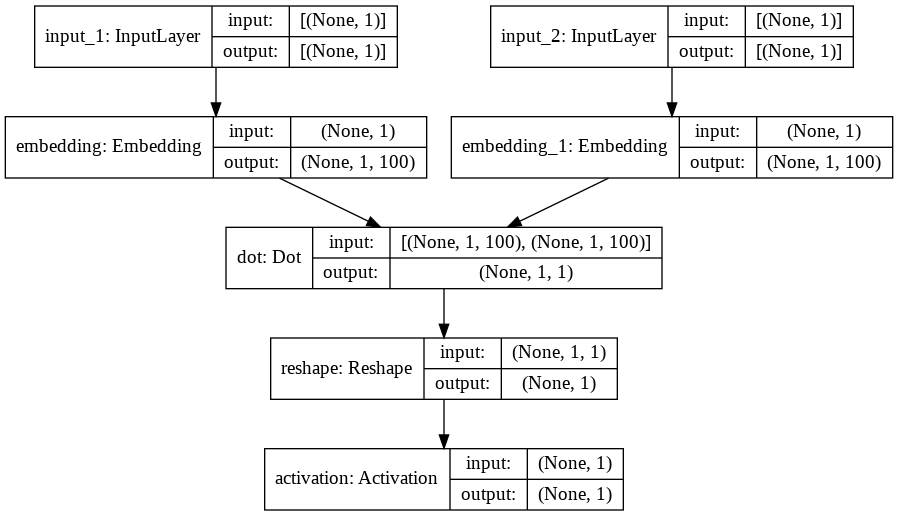

In [23]:
model = Model(inputs=[w_inputs, c_inputs], outputs=output)
model.summary()
model.compile(loss='binary_crossentropy', optimizer='adam')
plot_model(model, to_file='model3.png', show_shapes=True, show_layer_names=True, rankdir='TB')

In [ ]:
prob = []
for i in range(len(skip_grams)):
    if skip_grams[i] == ([], []):
        prob.append(i)
prob

In [25]:
skip_grams2 = [i for j, i in enumerate(skip_grams) if j not in prob]


In [26]:
for i in range(len(skip_grams2)):
    if skip_grams2[i] == ([], []):
        print(i)

In [27]:
for epoch in range(1, 2):
    loss = 0
    for _, elem in enumerate(skip_grams2):
        first_elem = np.array(list(zip(*elem[0]))[0], dtype='int32')
        second_elem = np.array(list(zip(*elem[0]))[1], dtype='int32')
        labels = np.array(elem[1], dtype='int32')
        X = [first_elem, second_elem]
        Y = labels
        loss += model.train_on_batch(X,Y)  
    print('Epoch :',epoch, 'Loss :',loss)

Epoch : 1 Loss : 4020.8748015407473


In [ ]:
train_x[177]

array([19,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
      dtype=int32)

In [28]:
f = open('vectors.txt' ,'w')
f.write('{} {}\n'.format(vocab_size-1, embed_size))
vectors = model.get_weights()[0]
for word, i in tokenizer.word_index.items():
    f.write('{} {}\n'.format(word, ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [55]:
n=0
f = open('vectors.txt', encoding="utf8")

for line in f:
    word_vector = line.split() # 각 줄을 읽어와서 word_vector에 저장.
    print(word_vector) # 각 줄을 출력
    word = word_vector[0] # word_vector에서 첫번째 값만 저장
    print(word) # word_vector의 첫번째 값만 출력
    n=n+1
    if n==3:
        break
f.close()

['190059', '100']
190059
['article', '0.15112208', '0.23108219', '0.01954909', '0.018274933', '-0.014386963', '0.09676274', '-0.18518867', '-0.23881768', '-0.011428517', '0.15622507', '-0.10962591', '-0.19072148', '-0.09256523', '-0.16419919', '-0.14698409', '0.23252156', '-0.174535', '-0.037536163', '0.061290327', '0.13222422', '0.19553366', '0.11687721', '0.070185594', '-0.29237103', '-0.09820505', '-0.058302455', '0.12689863', '0.09464098', '0.22676818', '0.14544833', '0.14660087', '0.2647539', '0.24162446', '0.09568407', '-0.07604063', '0.01773278', '0.1263433', '-0.2169172', '-0.11724046', '-0.14226215', '0.1305494', '0.08999007', '0.10157576', '0.24771753', '0.006380388', '0.019528389', '-0.22868541', '0.12690327', '-0.1373615', '0.26223594', '0.14252229', '-0.0526264', '0.051905174', '-0.08135065', '-0.19373739', '-0.17141391', '-0.108965464', '0.30094817', '-0.09186565', '0.1515811', '0.20490958', '0.056191277', '0.08076511', '0.1872546', '0.21582733', '-0.11789147', '-0.113656

In [40]:
word_vector

['page',
 '0.15633783',
 '0.21394496',
 '-0.056195397',
 '-0.0082274815',
 '-0.05940751',
 '0.13955042',
 '-0.11300678',
 '-0.1877507',
 '-0.0747516',
 '0.15470676',
 '0.0064689834',
 '-0.21834357',
 '-0.01883142',
 '-0.14393866',
 '-0.12968962',
 '0.17838277',
 '-0.27498555',
 '-0.010555059',
 '0.12898475',
 '0.18718791',
 '0.17567429',
 '0.19690324',
 '0.16692036',
 '-0.23145998',
 '0.050181676',
 '-0.11750904',
 '0.21602513',
 '0.06586257',
 '0.19784193',
 '0.15147267',
 '0.20391163',
 '0.1456512',
 '0.060806442',
 '-0.121844284',
 '0.06264838',
 '0.11610524',
 '0.21445316',
 '-0.179596',
 '-0.16324574',
 '-0.16507377',
 '0.03661973',
 '0.015390378',
 '0.21787602',
 '0.258558',
 '-0.09641574',
 '0.18956237',
 '-0.14453684',
 '0.04246791',
 '-0.2019157',
 '0.21012433',
 '0.28869614',
 '-0.09054346',
 '0.086227074',
 '-0.20133388',
 '-0.25692418',
 '-0.24599816',
 '-0.19709127',
 '0.20173195',
 '-0.014982932',
 '0.19112058',
 '0.22713287',
 '0.15484215',
 '0.22294512',
 '0.31162077',


In [41]:
print(type(word_vector))
print(len(word_vector))

<class 'list'>
101


In [57]:
if(type(word_vector) == list):
    print('yay')

yay


In [65]:
import numpy as np
embedding_dict = dict()
f = open('vectors.txt', encoding="utf8")
n=0
for line in f:
    n = n+1
    word_vector = line.split()
    word = word_vector[0]
    print(n)
    if word_vector[0] != 'talk':
        word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
        embedding_dict[word] = word_vector_arr
f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583

ValueError: ignored

In [61]:
embedding_dict

{}

In [ ]:
print(embedding_dict['good'])
print(len(embedding_dict['good']))

[-0.030769   0.11993    0.53909   -0.43696   -0.73937   -0.15345
  0.081126  -0.38559   -0.68797   -0.41632   -0.13183   -0.24922
  0.441      0.085919   0.20871   -0.063582   0.062228  -0.051234
 -0.13398    1.1418     0.036526   0.49029   -0.24567   -0.412
  0.12349    0.41336   -0.48397   -0.54243   -0.27787   -0.26015
 -0.38485    0.78656    0.1023    -0.20712    0.40751    0.32026
 -0.51052    0.48362   -0.0099498 -0.38685    0.034975  -0.167
  0.4237    -0.54164   -0.30323   -0.36983    0.082836  -0.52538
 -0.064531  -1.398     -0.14873   -0.35327   -0.1118     1.0912
  0.095864  -2.8129     0.45238    0.46213    1.6012    -0.20837
 -0.27377    0.71197   -1.0754    -0.046974   0.67479   -0.065839
  0.75824    0.39405    0.15507   -0.64719    0.32796   -0.031748
  0.52899   -0.43886    0.67405    0.42136   -0.11981   -0.21777
 -0.29756   -0.1351     0.59898    0.46529   -0.58258   -0.02323
 -1.5442     0.01901   -0.015877   0.024499  -0.58017   -0.67659
 -0.040379  -0.44043    0.0

In [ ]:
embedding_matrix_pg = np.zeros((vocab_size, 100))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix_pg)

(190060, 100)

In [ ]:
for word, i in tokenizer.word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
    temp = embedding_dict.get(word) # 단어(key) 해당되는 임베딩 벡터의 100개의 값(value)를 임시 변수에 저장
    if temp is not None:
        embedding_matrix_pg[i] = temp # 임수 변수의 값을 단어와 맵핑되는 인덱스의 행에 삽입

In [21]:
n=0
f = open('vectors.txt', encoding="utf8")

for line in f:
    word_vector = line.split() # 각 줄을 읽어와서 word_vector에 저장.
    print(word_vector) # 각 줄을 출력
    word = word_vector[0] # word_vector에서 첫번째 값만 저장
    print(word) # word_vector의 첫번째 값만 출력
    n=n+1
    if n==2:
        break
f.close()

['190059', '100']
190059
['article', '0.15112208', '0.23108219', '0.01954909', '0.018274933', '-0.014386963', '0.09676274', '-0.18518867', '-0.23881768', '-0.011428517', '0.15622507', '-0.10962591', '-0.19072148', '-0.09256523', '-0.16419919', '-0.14698409', '0.23252156', '-0.174535', '-0.037536163', '0.061290327', '0.13222422', '0.19553366', '0.11687721', '0.070185594', '-0.29237103', '-0.09820505', '-0.058302455', '0.12689863', '0.09464098', '0.22676818', '0.14544833', '0.14660087', '0.2647539', '0.24162446', '0.09568407', '-0.07604063', '0.01773278', '0.1263433', '-0.2169172', '-0.11724046', '-0.14226215', '0.1305494', '0.08999007', '0.10157576', '0.24771753', '0.006380388', '0.019528389', '-0.22868541', '0.12690327', '-0.1373615', '0.26223594', '0.14252229', '-0.0526264', '0.051905174', '-0.08135065', '-0.19373739', '-0.17141391', '-0.108965464', '0.30094817', '-0.09186565', '0.1515811', '0.20490958', '0.056191277', '0.08076511', '0.1872546', '0.21582733', '-0.11789147', '-0.113656

In [23]:
print(type(word_vector))
print(len(word_vector))

<class 'list'>
102


In [25]:
word_vector[0][0]

"'"

In [22]:
import numpy as np
embedding_dict = dict()
f = open('vectors.txt', encoding="utf8")

for line in f:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') # 100개의 값을 가지는 array로 변환
    embedding_dict[word] = word_vector_arr
f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

ValueError: ignored

In [17]:
embedding_dict

NameError: ignored

In [18]:
print(embedding_dict['good'])
print(len(embedding_dict['good']))

NameError: ignored

In [ ]:
embedding_matrix_pg = np.zeros((vocab_size, 100))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix_pg)

### 4. 모델

In [41]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Embedding, Input, GlobalMaxPool1D, Dropout, Flatten


In [42]:
import matplotlib.pyplot as plt
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

##### word embedding 없는 모델 
=> 학습 시간이 임베딩 한 것보다 훨씬 오래 걸림..

In [ ]:
def bm_gru_base(num_words, emb):
    input = Input(shape=(max_len,))
    x = Embedding(num_words, emb)(input)
    x = GRU(128)(x)
    x = Dropout(0.2)(x)
    x = Dense(50,activation = 'relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(6,activation = 'sigmoid')(x)

    model = Model(inputs = input, outputs=output)

    model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model


In [ ]:
model_gru = bm_gru_base(vocab_size, 300)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 300)          57018000  
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               165120    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306 

In [ ]:
hist_base = model_gru.fit(train_x, train_y, batch_size=32, epochs=10, validation_split = 0.2)

In [ ]:
acc_loss_plot(hist_base)

##### 워드 임베딩 모델

In [72]:
def bm_gru(embedding_matrix, emb):
    input = Input(shape=(max_len,))
    x = Embedding(vocab_size, emb, weights=[embedding_matrix], input_length=max_len, trainable=False)(input)
    x = GRU(128)(x)
    x = Dropout(0.2)(x)
    x = Dense(50,activation = 'relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(6,activation = 'sigmoid')(x)

    model = Model(inputs = input, outputs=output)

    model.compile(loss = 'binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    return model

##### pretrained w2v
sub_0401_pw2v_gru.csv => 0.96659 / 0.96649

In [ ]:
model_gru = bm_gru(embedding_matrix, 300)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 300)          57018000  
_________________________________________________________________
gru (GRU)                    (None, 128)               165120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306   

In [ ]:
hist = model_gru.fit(train_x, train_y, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
3988/3988 [==============================] - 84s 13ms/step - loss: 0.1056 - accuracy: 0.7772 - val_loss: 0.0549 - val_accuracy: 0.9941
Epoch 2/10
3988/3988 [==============================] - 52s 13ms/step - loss: 0.0522 - accuracy: 0.9877 - val_loss: 0.0527 - val_accuracy: 0.9941
Epoch 3/10
3988/3988 [==============================] - 52s 13ms/step - loss: 0.0489 - accuracy: 0.9932 - val_loss: 0.0492 - val_accuracy: 0.9941
Epoch 4/10
3988/3988 [==============================] - 52s 13ms/step - loss: 0.0452 - accuracy: 0.9897 - val_loss: 0.0508 - val_accuracy: 0.9941
Epoch 5/10
3988/3988 [==============================] - 52s 13ms/step - loss: 0.0418 - accuracy: 0.9908 - val_loss: 0.0505 - val_accuracy: 0.9940
Epoch 6/10
3988/3988 [==============================] - 52s 13ms/step - loss: 0.0387 - accuracy: 0.9896 - val_loss: 0.0518 - val_accuracy: 0.9937
Epoch 7/10
3988/3988 [==============================] - 52s 13ms/step - loss: 0.0359 - accuracy: 0.9850 - val_loss: 0.0588 -

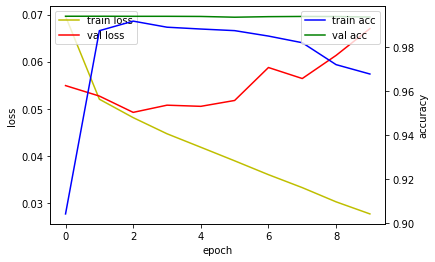

In [ ]:
acc_loss_plot(hist)

In [ ]:
model_gru.save('./0401_w2v_gru.h5')

In [ ]:
predict = model_gru.predict(test_x)
sample_submission.iloc[:, 1:] = predict

In [ ]:
sample_submission.to_csv("./sub_0401_pw2v_gru.csv", index=False)

##### pretrained_glove
sub_0401_pg_gru.csv => 0.96547 / 0.96723

In [ ]:
model_pg_gru = bm_gru(embedding_matrix_pg, 100)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 100)          19006000  
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               88320     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 306 

In [ ]:
hist_pg = model_pg_gru.fit(train_x, train_y, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
3988/3988 [==============================] - 68s 9ms/step - loss: 0.1224 - accuracy: 0.8046 - val_loss: 0.0578 - val_accuracy: 0.9941
Epoch 2/10
3988/3988 [==============================] - 35s 9ms/step - loss: 0.0575 - accuracy: 0.9886 - val_loss: 0.0540 - val_accuracy: 0.9941
Epoch 3/10
3988/3988 [==============================] - 35s 9ms/step - loss: 0.0517 - accuracy: 0.9851 - val_loss: 0.0523 - val_accuracy: 0.9941
Epoch 4/10
3988/3988 [==============================] - 35s 9ms/step - loss: 0.0489 - accuracy: 0.9853 - val_loss: 0.0506 - val_accuracy: 0.9941
Epoch 5/10
3988/3988 [==============================] - 35s 9ms/step - loss: 0.0448 - accuracy: 0.9882 - val_loss: 0.0509 - val_accuracy: 0.9941
Epoch 6/10
3988/3988 [==============================] - 35s 9ms/step - loss: 0.0419 - accuracy: 0.9884 - val_loss: 0.0514 - val_accuracy: 0.9941
Epoch 7/10
3988/3988 [==============================] - 35s 9ms/step - loss: 0.0389 - accuracy: 0.9893 - val_loss: 0.0527 - val_ac

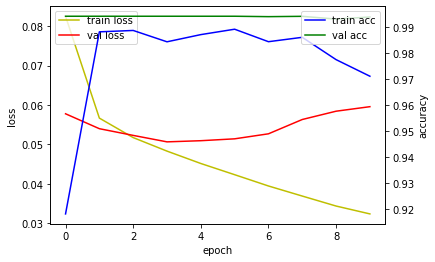

In [ ]:
acc_loss_plot(hist_pg)

In [ ]:
model_pg_gru.save('./0401_pg_gru.h5')

In [ ]:
predict = model_pg_gru.predict(test_x)
sample_submission.iloc[:, 1:] = predict
sample_submission.to_csv("./sub_0401_pg_gru.csv", index=False)

In [ ]:
sample_submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999961,4.692187e-01,9.974438e-01,2.032176e-01,9.617589e-01,4.436408e-01
1,0000247867823ef7,0.000048,1.359619e-13,1.274913e-07,3.402663e-10,1.798622e-07,3.629970e-08
2,00013b17ad220c46,0.000199,1.155575e-11,1.174685e-06,7.445456e-09,1.583080e-06,4.382553e-07
3,00017563c3f7919a,0.000030,4.679541e-14,9.847444e-08,9.297239e-11,1.227352e-07,9.238684e-09
4,00017695ad8997eb,0.000219,8.525992e-12,1.567509e-06,4.914833e-09,1.793466e-06,1.782565e-07
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.667438,6.739121e-04,2.975469e-01,9.626913e-04,1.368826e-01,1.559846e-04
153160,fffd7a9a6eb32c16,0.019426,4.503075e-07,3.154369e-04,9.337609e-05,4.560017e-04,4.139715e-04
153161,fffda9e8d6fafa9e,0.000038,5.691165e-14,1.028056e-07,1.128564e-10,1.356219e-07,1.348725e-08
153162,fffe8f1340a79fc2,0.000137,5.418562e-12,2.299492e-07,5.069589e-09,5.040666e-07,3.851945e-06


##### w2v cbow 
sub_0401_w2vc_gru.csv => 0.96948 / 0.96912  


In [ ]:
model_w2vc_gru = bm_gru(embedding_matrix_w2vc, 300)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 300)          57018000  
_________________________________________________________________
gru (GRU)                    (None, 128)               165120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306   

In [ ]:
hist_w2vc = model_w2vc_gru.fit(train_x, train_y, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
3988/3988 [==============================] - 222s 48ms/step - loss: 0.1135 - accuracy: 0.7919 - val_loss: 0.0558 - val_accuracy: 0.9941
Epoch 2/10
3988/3988 [==============================] - 191s 48ms/step - loss: 0.0531 - accuracy: 0.9908 - val_loss: 0.0561 - val_accuracy: 0.9940
Epoch 3/10
3988/3988 [==============================] - 190s 48ms/step - loss: 0.0491 - accuracy: 0.9924 - val_loss: 0.0522 - val_accuracy: 0.9937
Epoch 4/10
3988/3988 [==============================] - 189s 47ms/step - loss: 0.0467 - accuracy: 0.9862 - val_loss: 0.0514 - val_accuracy: 0.9940
Epoch 5/10
3988/3988 [==============================] - 189s 47ms/step - loss: 0.0440 - accuracy: 0.9908 - val_loss: 0.0542 - val_accuracy: 0.9941
Epoch 6/10
3988/3988 [==============================] - 190s 48ms/step - loss: 0.0410 - accuracy: 0.9904 - val_loss: 0.0525 - val_accuracy: 0.9939
Epoch 7/10
3988/3988 [==============================] - 189s 47ms/step - loss: 0.0390 - accuracy: 0.9905 - val_loss: 0

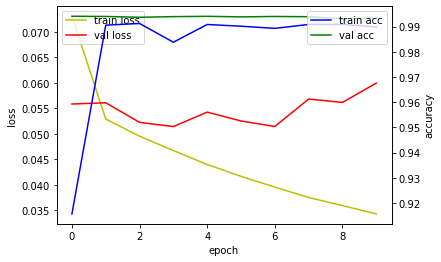

In [ ]:
acc_loss_plot(hist_w2vc)


In [ ]:
model_w2vc_gru.save('./0401_w2vc_gru.h5')

In [ ]:
predict = model_w2vc_gru.predict(test_x)
sample_submission.iloc[:, 1:] = predict
sample_submission.to_csv("./sub_0401_w2vc_gru.csv", index=False)

In [ ]:
sample_submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,9.974746e-01,3.714445e-01,9.528759e-01,1.695333e-01,8.419209e-01,2.218361e-01
1,0000247867823ef7,1.759608e-06,1.731691e-16,3.915771e-09,1.406001e-11,2.520952e-08,6.369218e-11
2,00013b17ad220c46,4.856231e-05,1.612076e-13,9.902084e-08,2.570069e-09,8.672760e-07,1.514528e-08
3,00017563c3f7919a,2.497950e-05,9.010182e-14,5.218579e-08,2.010997e-09,4.880212e-07,8.759314e-09
4,00017695ad8997eb,9.742688e-05,1.401877e-12,2.986479e-07,9.657416e-09,2.382649e-06,6.091928e-08
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,5.979321e-01,1.575942e-03,1.147773e-01,4.955770e-03,1.625287e-01,6.466639e-03
153160,fffd7a9a6eb32c16,4.836658e-05,2.926044e-13,7.122851e-08,4.940680e-09,1.032136e-06,3.286819e-08
153161,fffda9e8d6fafa9e,7.216426e-07,5.912899e-18,5.083908e-10,1.366879e-12,5.571763e-09,1.059338e-11
153162,fffe8f1340a79fc2,1.178651e-05,2.586323e-15,3.845217e-08,7.870532e-11,1.484273e-07,3.013914e-10


##### w2v cbow 2
window 10
mincount 40  
sub_0401_w2vc_gru_2.csv => 0.96703 / 0.96369

In [ ]:
model_w2vc_gru = bm_gru(embedding_matrix_w2vc, 300)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 300)          57018000  
_________________________________________________________________
gru (GRU)                    (None, 128)               165120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306   

In [ ]:
hist_w2vc = model_w2vc_gru.fit(train_x, train_y, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
3988/3988 [==============================] - 124s 24ms/step - loss: 0.1116 - accuracy: 0.8306 - val_loss: 0.0540 - val_accuracy: 0.9941
Epoch 2/10
3988/3988 [==============================] - 92s 23ms/step - loss: 0.0530 - accuracy: 0.9863 - val_loss: 0.0519 - val_accuracy: 0.9928
Epoch 3/10
3988/3988 [==============================] - 91s 23ms/step - loss: 0.0481 - accuracy: 0.9805 - val_loss: 0.0503 - val_accuracy: 0.9941
Epoch 4/10
3988/3988 [==============================] - 95s 24ms/step - loss: 0.0449 - accuracy: 0.9895 - val_loss: 0.0498 - val_accuracy: 0.9933
Epoch 5/10
3988/3988 [==============================] - 93s 23ms/step - loss: 0.0440 - accuracy: 0.9849 - val_loss: 0.0532 - val_accuracy: 0.9941
Epoch 6/10
3988/3988 [==============================] - 93s 23ms/step - loss: 0.0409 - accuracy: 0.9893 - val_loss: 0.0526 - val_accuracy: 0.9940
Epoch 7/10
3988/3988 [==============================] - 92s 23ms/step - loss: 0.0391 - accuracy: 0.9920 - val_loss: 0.0542 

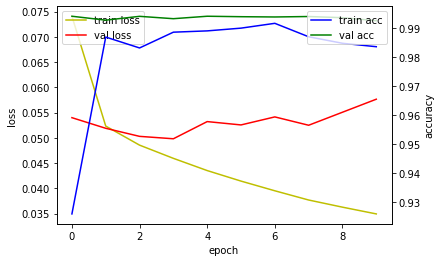

In [ ]:
acc_loss_plot(hist_w2vc)


In [ ]:
model_w2vc_gru.save('./0401_w2vc_gru_2.h5')

In [ ]:
predict = model_w2vc_gru.predict(test_x)
sample_submission.iloc[:, 1:] = predict
sample_submission.to_csv("./sub_0401_w2vc_gru_2.csv", index=False)

In [ ]:
sample_submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999989,4.246198e-01,9.962781e-01,1.640378e-01,9.414493e-01,6.964763e-01
1,0000247867823ef7,0.000006,2.369935e-13,1.483321e-07,1.084792e-12,2.859938e-08,2.915642e-10
2,00013b17ad220c46,0.000020,1.217536e-11,1.028915e-06,3.465580e-11,1.711930e-07,2.001431e-09
3,00017563c3f7919a,0.000012,5.514893e-12,6.833151e-07,1.563693e-11,8.597355e-08,1.043188e-09
4,00017695ad8997eb,0.028133,4.680154e-06,1.874506e-03,4.645765e-05,1.457851e-03,1.736494e-04
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.741061,4.824874e-05,1.144239e-01,2.220786e-04,1.335689e-01,1.889233e-04
153160,fffd7a9a6eb32c16,0.410382,2.532380e-04,1.766279e-02,1.045416e-02,5.146693e-02,4.056146e-03
153161,fffda9e8d6fafa9e,0.000008,8.198315e-13,2.430922e-07,2.410745e-12,4.787979e-08,1.441936e-09
153162,fffe8f1340a79fc2,0.000004,2.560166e-13,1.566832e-07,6.230588e-13,2.198587e-08,2.807997e-10


##### fasttext

sub_0401_ft_gru.csv => 0.96971 / 0.96916


In [44]:
model_ft_gru = bm_gru(embedding_matrix_ft, 300)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 300)          57018000  
_________________________________________________________________
gru (GRU)                    (None, 128)               165120    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 306 

In [45]:
hist_ft = model_ft_gru.fit(train_x, train_y, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
3988/3988 [==============================] - 119s 23ms/step - loss: 0.1049 - accuracy: 0.8169 - val_loss: 0.0471 - val_accuracy: 0.9941
Epoch 2/10
3988/3988 [==============================] - 94s 24ms/step - loss: 0.0475 - accuracy: 0.9907 - val_loss: 0.0454 - val_accuracy: 0.9941
Epoch 3/10
3988/3988 [==============================] - 94s 24ms/step - loss: 0.0450 - accuracy: 0.9916 - val_loss: 0.0452 - val_accuracy: 0.9939
Epoch 4/10
3988/3988 [==============================] - 93s 23ms/step - loss: 0.0415 - accuracy: 0.9884 - val_loss: 0.0433 - val_accuracy: 0.9933
Epoch 5/10
3988/3988 [==============================] - 94s 24ms/step - loss: 0.0389 - accuracy: 0.9919 - val_loss: 0.0440 - val_accuracy: 0.9939
Epoch 6/10
3988/3988 [==============================] - 96s 24ms/step - loss: 0.0359 - accuracy: 0.9903 - val_loss: 0.0446 - val_accuracy: 0.9939
Epoch 7/10
3988/3988 [==============================] - 97s 24ms/step - loss: 0.0339 - accuracy: 0.9923 - val_loss: 0.0465 

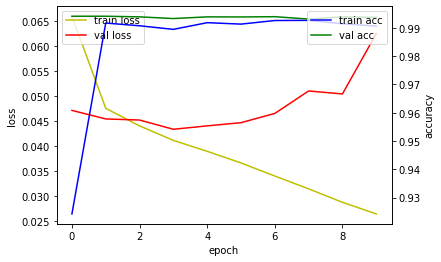

In [46]:
acc_loss_plot(hist_ft)

In [47]:
model_ft_gru.save('./0401_ft_gru.h5')

In [53]:
predict = model_ft_gru.predict(test_x)
sample_submission.iloc[:, 1:] = predict
sample_submission.to_csv("./sub_0401_ft_gru.csv", index=False)

In [54]:
sample_submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,9.999682e-01,3.089601e-01,9.972597e-01,4.725672e-03,9.420010e-01,5.038521e-02
1,0000247867823ef7,1.750737e-06,4.314048e-21,1.713162e-12,8.161217e-12,3.896151e-11,5.178975e-12
2,00013b17ad220c46,4.287360e-07,5.507528e-22,6.056923e-13,1.238077e-12,6.745516e-12,2.014541e-12
3,00017563c3f7919a,2.633390e-07,1.007167e-22,3.959587e-13,3.397192e-13,4.225256e-12,1.156876e-12
4,00017695ad8997eb,1.814443e-06,1.211341e-20,5.529774e-13,9.593822e-12,6.440094e-11,5.264500e-11
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,7.330607e-01,5.455144e-05,5.063122e-01,9.331635e-05,4.644059e-02,1.596669e-07
153160,fffd7a9a6eb32c16,8.043123e-07,3.591524e-21,7.615581e-13,4.867982e-12,1.673006e-11,6.173314e-12
153161,fffda9e8d6fafa9e,4.685191e-07,8.970649e-23,4.023415e-13,4.937561e-13,5.851938e-12,8.400691e-13
153162,fffe8f1340a79fc2,3.480646e-07,1.643497e-22,7.468506e-14,4.945223e-13,6.068061e-12,8.626873e-12


##### glove

sub_0401_g_gru.csv => 0.94440 / 0.94847

In [115]:
model_g_gru = bm_gru(embedding_matrix_g, 300)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 150, 300)          57018000  
_________________________________________________________________
gru_2 (GRU)                  (None, 128)               165120    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306 

In [116]:
hist_g = model_g_gru.fit(train_x, train_y, batch_size=32, epochs=10, validation_split = 0.2)

Epoch 1/10
3988/3988 [==============================] - 104s 26ms/step - loss: 0.1351 - accuracy: 0.7936 - val_loss: 0.0765 - val_accuracy: 0.9941
Epoch 2/10
3988/3988 [==============================] - 104s 26ms/step - loss: 0.0760 - accuracy: 0.9943 - val_loss: 0.0728 - val_accuracy: 0.9941
Epoch 3/10
3988/3988 [==============================] - 105s 26ms/step - loss: 0.0691 - accuracy: 0.9938 - val_loss: 0.0669 - val_accuracy: 0.9941
Epoch 4/10
3988/3988 [==============================] - 103s 26ms/step - loss: 0.0649 - accuracy: 0.9934 - val_loss: 0.0652 - val_accuracy: 0.9940
Epoch 5/10
3988/3988 [==============================] - 105s 26ms/step - loss: 0.0603 - accuracy: 0.9939 - val_loss: 0.0639 - val_accuracy: 0.9941
Epoch 6/10
3988/3988 [==============================] - 105s 26ms/step - loss: 0.0576 - accuracy: 0.9940 - val_loss: 0.0641 - val_accuracy: 0.9941
Epoch 7/10
3988/3988 [==============================] - 105s 26ms/step - loss: 0.0534 - accuracy: 0.9941 - val_loss: 0

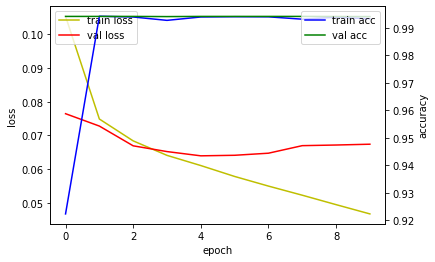

In [117]:
acc_loss_plot(hist_g)

In [118]:
model_g_gru.save('./0401_g_gru.h5')

In [119]:
predict = model_g_gru.predict(test_x)
sample_submission.iloc[:, 1:] = predict
sample_submission.to_csv("./sub_0401_g_gru.csv", index=False)

In [120]:
sample_submission

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.998439,2.355844e-01,0.972255,2.769388e-02,0.892907,1.124564e-01
1,0000247867823ef7,0.001292,1.610639e-08,0.000077,2.546426e-06,0.000058,2.116142e-05
2,00013b17ad220c46,0.057591,5.441833e-05,0.009862,8.569905e-05,0.013561,1.412427e-03
3,00017563c3f7919a,0.000345,8.495321e-10,0.000053,7.256298e-09,0.000023,2.002457e-06
4,00017695ad8997eb,0.000408,9.482835e-11,0.000069,7.243324e-10,0.000018,5.303440e-07
...,...,...,...,...,...,...,...
153159,fffcd0960ee309b5,0.786392,8.510220e-03,0.261716,2.160368e-03,0.441051,1.005873e-02
153160,fffd7a9a6eb32c16,0.432060,3.950079e-02,0.271977,1.728553e-02,0.324899,6.528378e-02
153161,fffda9e8d6fafa9e,0.000742,1.715235e-09,0.000082,9.855107e-09,0.000042,2.943059e-06
153162,fffe8f1340a79fc2,0.002019,2.657998e-08,0.000222,4.798809e-07,0.000184,3.103892e-05
